In [5]:
#https://blog.csdn.net/fangchenglia/article/details/125725093
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
from matplotlib import pyplot as plt
import os
from MazeEnv import MazeEnv
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# env = gym.make('Pendulum-v1').unwrapped
env = MazeEnv(5, 5)


'''Pendulum环境状态特征是三个，杆子的sin(角度)、cos（角度）、角速度，（状态是无限多个，因为连续），动作值是力矩，限定在[-2,2]之间的任意的小数，所以是连续的（动作也是无限个）'''
# state_number=env.observation_space.shape[0]
# action_number=env.action_space.shape[0]
# max_action = env.action_space.high[0]
# min_action = env.action_space.low[0]

state_number = env.get_n_states()
action_number = env.get_n_actions()
max_action = 0.99999
min_action = -0.99999

torch.manual_seed(0)#如果你觉得定了随机种子不能表达代码的泛化能力，你可以把这两行注释掉
# env.seed(0) 
RENDER=False
ITER_MAX = 200
EP_MAX = 500
EP_LEN = 40
GAMMA = 0.99
A_LR = 0.0001
C_LR = 0.0003
BATCH = 128
A_UPDATE_STEPS = 10
C_UPDATE_STEPS = 10
METHOD = [
    dict(name='kl_pen', kl_target=0.01, lam=0.5),   # KL penalty
    dict(name='clip', epsilon=0.2),                 # Clipped surrogate objective, find this is better
][1]        # choose the method for optimization
Switch=0
'''由于PPO也是基于A-C框架，所以我把PPO的编写分为两部分，PPO的第一部分 Actor'''
'''PPO的第一步  编写A-C框架的网络，先编写actor部分的actor网络，actor的网络有新与老两个网络'''

class ActorNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3_1 = nn.Linear(hidden_dim, output_dim)
        self.fc3_2 = nn.Linear(hidden_dim, output_dim)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))        
        mean=torch.tanh(self.fc3_1(x))#输出概率分布的均值mean-1~1   TODO
        std=F.softplus(self.fc3_2(x))#softplus激活函数的值域>0
        return mean, std
    
class CriticNet(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dim=256):
        super(CriticNet,self).__init__()
        assert output_dim == 1 # critic must output a single value
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value 
    
class Actor():
    def __init__(self):
        self.old_pi,self.new_pi=ActorNet(state_number,action_number),ActorNet(state_number,action_number)#这只是均值mean
        self.optimizer=torch.optim.Adam(self.new_pi.parameters(),lr=A_LR,eps=1e-5)
    '''第二步 编写根据状态选择动作的函数'''
    def choose_action(self,s):
        inputstate = torch.FloatTensor(s)
        mean,std=self.old_pi(inputstate)
        dist = torch.distributions.Normal(mean, std)
        action=dist.sample()
        action=torch.clamp(action,min_action,max_action)
        action_logprob=dist.log_prob(action) # 
        return action.detach().numpy(),action_logprob.detach().numpy()
    
    def choose_action2(self,s):
        inputstate = torch.FloatTensor(s)
        mean,std=self.old_pi(inputstate) # TODO
        print(mean, std)
        dist = torch.distributions.Normal(mean, std)
        action=mean
        action=torch.clamp(action,min_action,max_action)
        action_logprob=dist.log_prob(action)
        return action.detach().numpy(),action_logprob.detach().numpy()
    
    '''第四步  actor网络有两个策略（更新old策略）————————把new策略的参数赋给old策略'''
    def update_oldpi(self):
        self.old_pi.load_state_dict(self.new_pi.state_dict())
    '''第六步 编写actor网络的学习函数，采用PPO2，即OpenAI推出的clip形式公式'''
    def learn(self,bs,ba,adv,bap): #buffer_s, buffer_a, advantage, buffer_a_logp
        bs = torch.FloatTensor(bs)
        ba = torch.FloatTensor(ba)
        adv = torch.FloatTensor(adv)
        bap = torch.FloatTensor(bap)
        for _ in range(A_UPDATE_STEPS):
            mean, std = self.new_pi(bs)
            dist_new=torch.distributions.Normal(mean, std)
            action_new_logprob=dist_new.log_prob(ba)
            ratio=torch.exp(action_new_logprob - bap.detach())
            surr1 = ratio * adv
            surr2 = torch.clamp(ratio, 1 - METHOD['epsilon'], 1 + METHOD['epsilon']) * adv
            loss = -torch.min(surr1, surr2)
            loss=loss.mean()
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.new_pi.parameters(), 0.5)
            self.optimizer.step()
class Critic():
    def __init__(self):
        self.critic_v=CriticNet(state_number,1) #改网络输入状态，生成一个V值
        self.optimizer = torch.optim.Adam(self.critic_v.parameters(), lr=C_LR,eps=1e-5)
        self.lossfunc = nn.MSELoss()
    '''第三步  编写评定动作价值的函数'''
    def get_v(self,s):
        inputstate = torch.FloatTensor(s)
        return self.critic_v(inputstate)
    '''第五步  计算优势——————advantage，后面发现第五步计算出来的adv可以与第七步合为一体，所以这里的代码注释了，但是，计算优势依然算是可以单独拎出来的一个步骤'''
    # def get_adv(self,bs,br):
    #     reality_v=torch.FloatTensor(br)
    #     v=self.get_v(bs)
    #     adv=(reality_v-v).detach()
    #     return adv
    '''第七步  编写actor-critic的critic部分的learn函数，td-error的计算代码（V现实减去V估计就是td-error）'''
    def learn(self,bs,br):
        bs = torch.FloatTensor(bs)
        reality_v = torch.FloatTensor(br)
        for _ in range(C_UPDATE_STEPS):
            v=self.get_v(bs)
            td_e = self.lossfunc(reality_v, v)
            self.optimizer.zero_grad()
            td_e.backward()
            nn.utils.clip_grad_norm_(self.critic_v.parameters(), 0.5) #是否需要需要考虑
            self.optimizer.step()
        return (reality_v-v).detach()
        
def train():
    print('PPO2训练中...')
    actor=Actor()
    critic=Critic()
    
    all_ep_r = []
    for iteration in range(ITER_MAX): # iteration
        b_s, b_a, b_r,b_a_logp, d_r = [], [], [], [], []
        reward_totle=0
        done_totle=0
        for episode in range(EP_MAX):
            done = False
            buffer_s, buffer_a, buffer_r, buffer_a_logp , discounted_r= [], [], [],[], []
            observation = env.reset() #环境重置
            
            for timestep in range(EP_LEN):
                if RENDER:
                    env.render()
                action,action_logprob=actor.choose_action(observation)    
                
                observation_, reward, done, info = env.step(action)
                buffer_s.append(observation)
                buffer_a.append(action)
                buffer_r.append(reward)
                buffer_a_logp.append(action_logprob)
                
                observation=observation_
                reward_totle+=reward  
                                
                # if(done or (observation_ in buffer_s)):
                if(done):
                    # print(done_totle)
                    done_totle += 1
                    break
                    
            if(done):
                v_observation_ = torch.tensor([1e-8])
            else:
                v_observation_ = critic.get_v(observation_)
            # print(v_observation_ , reward,  GAMMA)
            for reward in buffer_r[::-1]:
                v_observation_ = reward + GAMMA * v_observation_
                discounted_r.append(v_observation_.detach().numpy())   # 没有转成A
            discounted_r.reverse()
            b_s += buffer_s
            b_a += buffer_a
            b_r += buffer_r
            b_a_logp += buffer_a_logp
            d_r += discounted_r
            
        d_r = torch.tensor(d_r, dtype=torch.float32)
        d_r = (d_r - d_r.mean()) / (d_r.std() + 1e-5) 
        bs, ba, dr, bap = np.vstack(b_s), np.vstack(b_a), np.array(d_r),np.vstack(b_a_logp)

        for _ in range(10):
            msk = np.random.rand(len(bs)) < 0.2
            
            advantage=critic.learn(bs[msk],dr[msk])#critic部分更新
            actor.learn(bs[msk],ba[msk],advantage,bap[msk])#actor部分更新
            
        actor.update_oldpi()  # pi-new的参数赋给pi-old
        # critic.learn(bs,br)
            
            
        if iteration == 0:
            all_ep_r.append(reward_totle)
        else:
            all_ep_r.append(all_ep_r[-1] * 0.9 + reward_totle * 0.1)
            
        print("\rIter: {} |rewards: {} | dones: {}".format(iteration, round(reward_totle/EP_MAX,4), round(done_totle/EP_MAX,4)), end="\n")
        #保存神经网络参数
        if iteration % 10 == 0 and iteration > 1:#保存神经网络参数
            save_data = {'net': actor.old_pi.state_dict(), 'opt': actor.optimizer.state_dict(), 'i': episode}
            torch.save(save_data, "./model/PPO2_model_actor.pth")
            save_data = {'net': critic.critic_v.state_dict(), 'opt': critic.optimizer.state_dict(), 'i': episode}
            torch.save(save_data, "./model/PPO2_model_critic.pth")
    
    env.close()
    plt.plot(np.arange(len(all_ep_r)), all_ep_r)
    plt.xlabel('Episode')
    plt.ylabel('Moving averaged episode reward')
    plt.show()

def test(num):
    print('PPO2测试中...')
    aa=Actor()
    cc=Critic()
    checkpoint_aa = torch.load("./model/PPO2_model_actor.pth")
    aa.old_pi.load_state_dict(checkpoint_aa['net'])
    checkpoint_cc = torch.load("./model/PPO2_model_critic.pth")
    cc.critic_v.load_state_dict(checkpoint_cc['net'])
    for j in range(num):
        state = env.reset()
        total_rewards = 0

        for timestep in range(EP_LEN):
            # env.render()
            env.draw_maze()
            action, action_logprob = aa.choose_action(state)
            # env.show_action(action)
            new_state, reward, done, info = env.step(action)  # 执行动作
            total_rewards += reward
            state = new_state
            if(done):
                break
        print(f"Score：{round(total_rewards,2)}, {done}")
    env.close()

PPO2训练中...
Iter: 0 |rewards: -15.3855 | dones: 0.01
Iter: 1 |rewards: -12.4134 | dones: 0.044
Iter: 2 |rewards: -11.7577 | dones: 0.022
Iter: 3 |rewards: -9.5887 | dones: 0.028
Iter: 4 |rewards: -8.323 | dones: 0.022
Iter: 5 |rewards: -6.5005 | dones: 0.02
Iter: 10 |rewards: -2.9649 | dones: 0.044
Iter: 11 |rewards: -2.2168 | dones: 0.048
Iter: 12 |rewards: -2.2169 | dones: 0.036
Iter: 13 |rewards: -2.0129 | dones: 0.044
Iter: 14 |rewards: -1.8219 | dones: 0.05
Iter: 15 |rewards: -1.5839 | dones: 0.058
Iter: 16 |rewards: -0.7853 | dones: 0.058
Iter: 17 |rewards: -0.4805 | dones: 0.044
Iter: 18 |rewards: -0.1754 | dones: 0.074
Iter: 19 |rewards: -0.7223 | dones: 0.046
Iter: 20 |rewards: -0.3448 | dones: 0.06
Iter: 21 |rewards: 0.3391 | dones: 0.076
Iter: 22 |rewards: 0.9403 | dones: 0.07
Iter: 23 |rewards: 1.2312 | dones: 0.098
Iter: 24 |rewards: 0.5849 | dones: 0.056
Iter: 25 |rewards: 1.2334 | dones: 0.082
Iter: 26 |rewards: 1.2344 | dones: 0.064
Iter: 27 |rewards: 1.3388 | dones: 0.1

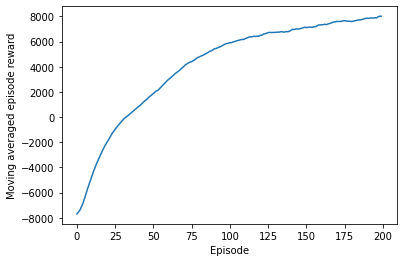

In [6]:
train()

PPO2测试中...


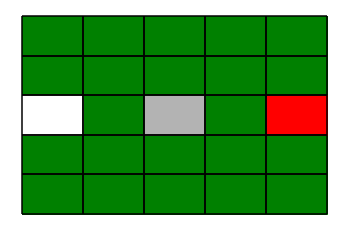

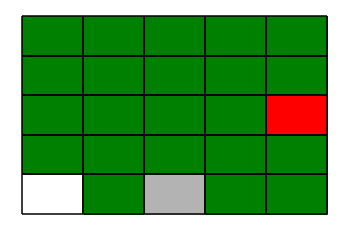

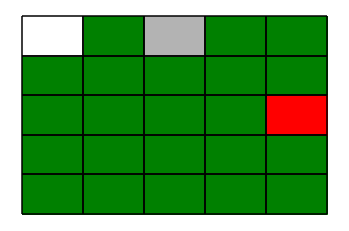

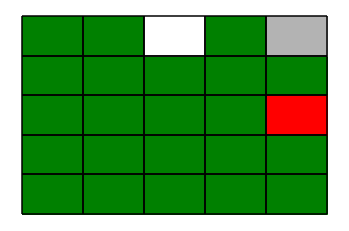

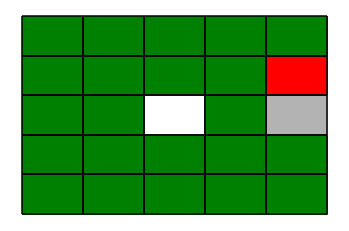

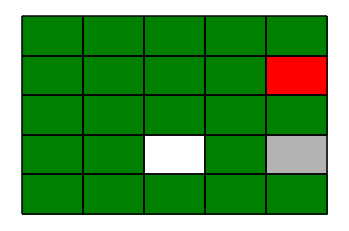

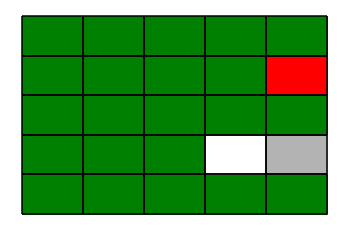

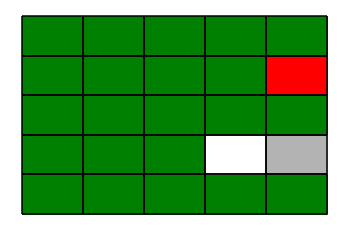

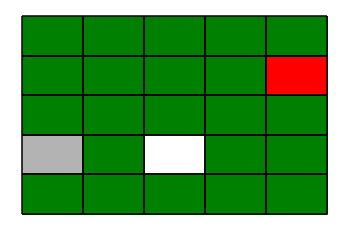

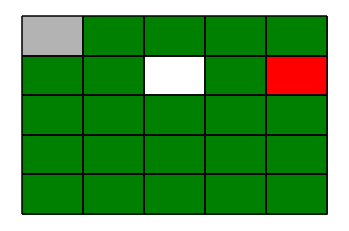

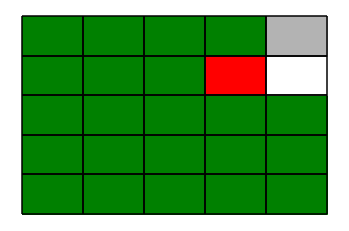

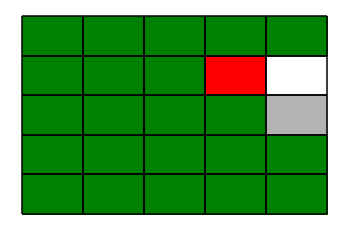

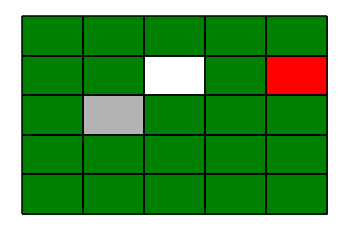

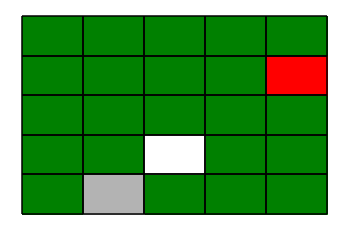

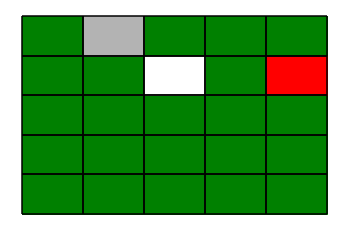

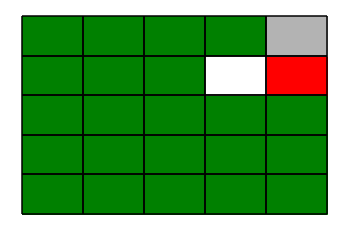

Score：12.02, True


In [23]:
def test(num):
    print('PPO2测试中...')
    aa=Actor()
    cc=Critic()
    checkpoint_aa = torch.load("./model/PPO2_model_actor.pth")
    aa.old_pi.load_state_dict(checkpoint_aa['net'])
    checkpoint_cc = torch.load("./model/PPO2_model_critic.pth")
    cc.critic_v.load_state_dict(checkpoint_cc['net'])
    for j in range(num):
        state = env.reset()
        total_rewards = 0

        for timestep in range(EP_LEN):
            # env.render()
            env.draw_maze()
            action, action_logprob = aa.choose_action(state)
            # env.show_action(action)
            new_state, reward, done, info = env.step(action)  # 执行动作
            total_rewards += reward
            state = new_state
            if(done):
                break
        print(f"Score：{round(total_rewards,2)}, {done}")
    env.close()
test(1)

In [18]:
print(type(np.array([1.1], dtype='float64')))

<class 'numpy.ndarray'>


In [19]:
import random
random.uniform(-1,1)

-0.48409809683721594

State: (5, 5, 1, 0, 4, 2)


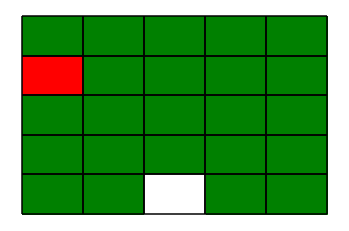

[('^', 3)]
0.13700000000000018
[('<', 1)]
0.039000000000000055
[('v', 3)]
-0.16299999999999984
[('<', 0)]
-1.01
[('>', 1)]
-0.06099999999999994
[('>', 0)]
-1.01
[('<', 2)]
0.08800000000000012
[('>', 3)]
-0.16299999999999984
[('v', 0)]
-1.01
[('<', 3)]
0.13700000000000018
[('^', 0)]
-1.01
[('<', 0)]
-1.01
[('>', 4)]
-0.21399999999999977
[('<', 3)]
0.13700000000000018
[('>', 3)]
-0.16299999999999984
[('^', 1)]
0.039000000000000055
[('<', 4)]
0.18600000000000022
[('<', 0)]
-1.01
[('>', 2)]
-0.11199999999999989
[('v', 0)]
-1.01
[('>', 0)]
-1.01
[('^', 3)]
0.03700000000000017
[('v', 1)]
0.039000000000000055
[('>', 0)]
-1.01
[('<', 2)]
0.039000000000000055
[('v', 1)]
-0.06099999999999994
[('<', 0)]
-1.01
[('<', 0)]
-1.01
[('<', 0)]
-1.01
[('^', 2)]
-0.011999999999999886
[('<', 0)]
-1.01
[('^', 0)]
-1.01
[('>', 2)]
-0.011999999999999886
[('>', 1)]
-0.06099999999999994
[('<', 2)]
0.08800000000000012
[('v', 3)]
61.03799999999999
[('<', 0)]
-1.01
[('>', 3)]
-0.013000000000010914
[('^', 3)]
-0.01

In [15]:
from MazeEnv import MazeEnv

maze = MazeEnv(5, 5)
# for i in range(10):
print("State:", maze.get_state())
maze.draw_maze()
for i in range(100):
    action = maze.random_action()
    maze.show_action(action)
    next_state, reward, done, info  = maze.step(action)
    print(reward)
    # print(reward)
    # print("Action:", action)
    # maze.draw_maze()

In [29]:
x=[1,2,3]
x[::-1]

[3, 2, 1]